### Code with one msh, dat, xdmf files and plots of disp, stress and files of P vs d and stress vs strain is generated


0.0
Iterations: 1 , Total time: 30.0
Solving linear variational problem.
74.43791109120573
Iterations: 2 , Total time: 60.0
Solving linear variational problem.
148.87582218241147
Iterations: 3 , Total time: 90.0
Solving linear variational problem.
223.31373327369374
Iterations: 4 , Total time: 120.0
Solving linear variational problem.
297.75164436482294
Iterations: 5 , Total time: 150.0
Solving linear variational problem.
372.1895554560948
Iterations: 6 , Total time: 180.0
Solving linear variational problem.
446.6274665473875
Iterations: 7 , Total time: 210.0
Solving linear variational problem.
521.0653776385221
Iterations: 8 , Total time: 240.0
Solving linear variational problem.
595.5032887296459
Iterations: 9 , Total time: 240.3
Solving linear variational problem.
596.2476678406565
Iterations: 10 , Total time: 240.60000000000002
Solving linear variational problem.
596.9920469513353
Iterations: 11 , Total time: 240.90000000000003
Solving linear variational problem.
597.7364260622973

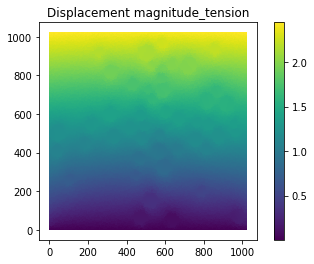

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt

mesh_from_file = meshio.read("/mnt/d/Research Projects/FEniCS/mini_automation/automation/msh files/1.msh")

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("/mnt/d/Research Projects/FEniCS/mini_automation/automation/mat_xdmf/1.xdmf", triangle_mesh)

from dolfin import * 
mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/mini_automation/automation/mat_xdmf/1.xdmf") as infile:
    infile.read(mesh)

def extract_fourth_column(dat_file):
    fourth_column = []
    with open(dat_file, "r") as file:
        for line in file:
            elements = line.strip().split()
            fourth_column.append(int(elements[3]))  # Assuming the fourth column is at index 3
    return fourth_column

# Provide the path to the DAT file
dat_file = "/mnt/d/Research Projects/FEniCS/mini_automation/automation/dat/1.dat"

# Extract the fourth column elements
fourth_column_array = extract_fourth_column(dat_file)
fourth_column_array

import dolfin

materials = MeshFunction('double', mesh, 2)

G = VectorFunctionSpace(mesh, "CG", 2)
g = Function(G)

local_values_material = np.zeros_like(g.vector().get_local())

for cell in cells(mesh):
    midpoint = cell.midpoint().array()
    i = (midpoint[0])
    j = (midpoint[1])
    k = (midpoint[2])
    local_values_material[cell.index()] = fourth_column_array[cell.index()]
    materials[cell] = int(local_values_material[cell.index()])
    
g.vector().set_local(local_values_material)

dolfin.XDMFFile(dolfin.MPI.comm_world, "/mnt/d/Research Projects/FEniCS/mini_automation/automation/mat_xdmf/1.xdmf").write_checkpoint(g,"g",0)

import dolfin as dol
class al(dol.UserExpression):
    def __init__(self, materials, al0, al1, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.k_0 = al0
        self.k_1 = al1
    def eval_cell(self, values, x, cell):
        if self.materials[cell.index] == 0:
            values[0] = self.k_0
        else:
            values[0] = self.k_1
            
E1 = 21e3 #(matrix)
nu1 = 0.3
E2 = 2100e3 #(inclusion)
nu2 = 0.25

E = al(materials, E1, E2, degree = 0)
nu = al(materials, nu1, nu2, degree = 0)

# Define Space
V = FunctionSpace(mesh, 'CG', 1)
W = VectorFunctionSpace(mesh, 'CG', 1)
WW = FunctionSpace(mesh, 'DG', 0)
u, v = TrialFunction(W), TestFunction(W)
d = u.geometric_dimension()
    
model = "plane_stress"
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)
    
# Constituive functions
def epsilon(u):
    return sym(grad(u))
def sigma(u):
    return 2.0*mu*epsilon(u)+lmbda*tr(epsilon(u))*Identity(len(u))

    # Boundary conditions
top = CompiledSubDomain("near(x[1], 1023.) && on_boundary")
bot = CompiledSubDomain("near(x[1], 0.) && on_boundary")

load = Expression("t", t = 0.0, degree=1)
bcbot= DirichletBC(W, Constant((0.0,0.0)), bot)
bctop = DirichletBC(W.sub(1), load, top)
bc_u = [bcbot, bctop]

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
top.mark(boundaries,1)

ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)
    
# Variational form
unew, uold = Function(W), Function(W)

E_du = inner(sigma(u), epsilon(v))*dx
p_disp = LinearVariationalProblem(lhs(E_du), rhs(E_du), unew, bc_u)
solver_disp = LinearVariationalSolver(p_disp)

# Initialization of the iterative procedure and output requests
t = 0
u_r = 0.01
deltaT  = 30.
deltaT1 = deltaT/100.
iter = 0
fname1 = open('ForcevsDisp_f1.txt', 'w')
fname2 = open('stress[1, 1]vsstrain[1, 1]_f1.txt', 'w')

s = sigma(unew) - (1./3)*tr(sigma(unew))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
von_Mises = project(von_Mises, WW)
vm = von_Mises.vector().max()
print(vm)
    
# yield stress = 600 MPa
sigmaYS = 600.
while vm < sigmaYS:
    if vm > 0.9*sigmaYS:
        t += deltaT1   
    else:
        t += deltaT 
        
    load.t= t*u_r
    iter += 1
    
    print ('Iterations:', iter, ', Total time:', t)
    solver_disp.solve()
                    
    uold.assign(unew)

    s = sigma(unew) - (1./3)*tr(sigma(unew))*Identity(d) 
    von_Mises = sqrt(3./2*inner(s, s))
    von_Mises = project(von_Mises, WW)
    vm = von_Mises.vector().max()
    
    if vm > sigmaYS:
        break
        
    print(vm)

    Traction = dot(sigma(unew),n)
    fy = Traction[1]*ds(1)
                
    fname1.write(str(t*u_r) + "\t")
    fname1.write(str(assemble(fy)) + "\n")
                
    strain = epsilon(unew)
    strain_function = project(strain[1, 1], V)
    strain_at_point = strain_function((511.5, 1023.))
     
    stress = sigma(unew)
    stress_function = project(stress[1, 1], V)
    stress_at_point = stress_function((511.5, 1023.))
        
    fname2.write(str(strain_at_point) + "\t")
    fname2.write(str(stress_at_point) + "\n")
                
fname1.close()
fname2.close()
print ('Simulation completed') 

#Compute magnitude of displacement
u_magnitude = sqrt(dot(unew, unew))
u_magnitude = project(u_magnitude, WW)
print('max_u:',u_magnitude.vector().max())
h = plot(u_magnitude, title = 'Displacement magnitude_tension')
plt.colorbar(h)
plt.show()

max_vonmises: 600.7139425061914


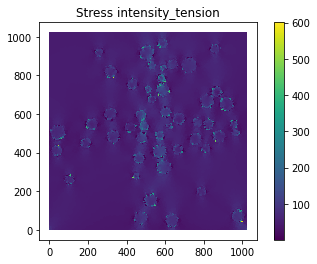

In [2]:
#Code for stress plot
s = sigma(unew) - (1./3)*tr(sigma(unew))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
von_Mises = project(von_Mises, WW)
print('max_vonmises:',von_Mises.vector().max())
w = plot(von_Mises, title='Stress intensity_tension')
plt.colorbar(w)
plt.show()